In [1]:
!pip install py7zr

In [2]:
import pandas as pd
import numpy as np
import py7zr
import os
import matplotlib.pyplot as plt
import seaborn as sns

https://www.kaggle.com/code/suchadapleasong/iceberg


**`EXPLORATORY DATA ANALYSIS`**

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
from google.colab import files
uploaded = files.upload()

KeyboardInterrupt: 

In [5]:
import zipfile
import os

zipfile_path = '/content/statoil-iceberg-classifier-challenge.zip'
#zipfile_path = '/kaggle/statoil-iceberg-classifier-challenge.zip'

with zipfile.ZipFile(zipfile_path, "r") as z:
    z.extractall("/kaggle/working")   # extract to working directory

with zipfile.ZipFile(zipfile_path, "r") as z1:
    z1.extractall("/kaggle/working")

# check what files are extracted
print(os.listdir("/kaggle/working"))

['train.json.7z', 'test.json.7z', 'sample_submission.csv.7z']


In [6]:
with py7zr.SevenZipFile('/kaggle/working/train.json.7z', mode='r') as z:
    z.extractall()
    #print(z.getnames())

with py7zr.SevenZipFile('/kaggle/working/test.json.7z', mode='r') as z1:
    z1.extractall()
    #print(z1.getnames())

The pixel intensity values are often converted to a physical quantity called the backscattering coefficient or normalised radar cross-section measured in decibel (dB) units with values ranging from +5 dB for very bright objects to -40 dB for very dark surfaces.

In [7]:
# data/processed/test.json
# data/processed/train.json

train = pd.read_json('data/processed/train.json')
test = pd.read_json('data/processed/test.json')

train.head(5)

,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


In [8]:
# check if there are null values in any column
inc_angle_na = train['inc_angle'].isna().sum()
is_iceberg_na = train['is_iceberg'].isna().sum()
band_1_na = train['band_1'].isna().sum()
band_2_na = train['band_2'].isna().sum()

print(f'inc_angle_na: {inc_angle_na}')
print(f'is_iceberg_na: {is_iceberg_na}')
print(f'inc_angle_na: {band_1_na}')
print(f'is_iceberg_na: {band_2_na}')

inc_angle_na: 0
is_iceberg_na: 0
inc_angle_na: 0
is_iceberg_na: 0


In [9]:
# drop id columns in test and train, not needed
# train.drop('id', axis=1, inplace = True)
# test.drop('id', axis=1, inplace = True)

In [10]:
total_num_icebergs = train['is_iceberg'] == 1
print("is iceberg:" , total_num_icebergs.sum())

total_num_ships = train['is_iceberg'] == 0
print("is ship:   " , total_num_ships.sum())

is iceberg: 753
is ship:    851


In [11]:
# each array in band_1 and band_2 has 5625 values.
band_1 = np.array(train['band_1'].head())
band_2 = np.array(train['band_2'].head())

print ("band 1 array size:", len(band_1[0]))
print ("band 2 array size:", len(band_2[0]))

# get singular values for band1 mean and median
band1_mean = np.mean(np.mean(band_1))
band1_median = np.median(np.median(band_1))
#band1_std = np.std(band_1)

print("\nband_1 mean:", band1_mean)
print("band_1 median:", band1_median)
#print(band1_std)

# get singular values for band2 mean and median
band2_mean = np.mean(np.mean(band_2))
band2_median = np.median(np.median(band_2))
#band2_std = np.std(band_2)

print("\nband_2 mean:", band2_mean)
print("band_2 median:", band2_median)
#print(band2_std)

band 1 array size: 5625
band 2 array size: 5625

band_1 mean: -4.520883768967111
band_1 median: -22.935019

band_2 mean: -5.4121873680284445
band_2 median: -25.466921


https://www.kaggle.com/code/suchadapleasong/iceberg


**`RESCALE IMAGES + ADD THIRD BAND`**

In [12]:
def get_scaled_imgs(df):
    imgs = []

    for i, row in df.iterrows():

        # make 75x75 image
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 + band_2

        a = (band_1 - band_1.mean()) / (band_1.max() - band_1.min())
        b = (band_2 - band_2.mean()) / (band_2.max() - band_2.min())
        c = (band_3 - band_3.mean()) / (band_3.max() - band_3.min())

        imgs.append(np.dstack((a, b, c)))
    return np.array(imgs)

data = get_scaled_imgs(train) # use this on the train set
target = np.array(train['is_iceberg']) # used to print out just the labels from is_iceberg

print(data.shape)
print(target.shape)

(1604, 75, 75, 3)
(1604,)


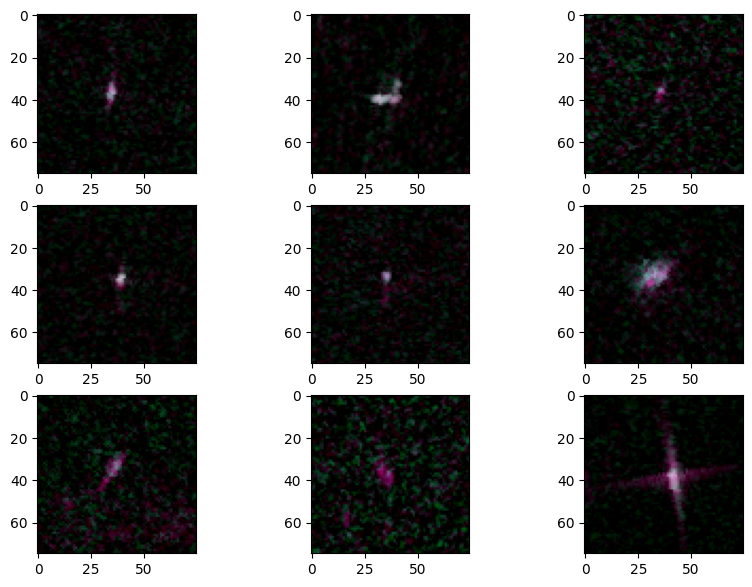

In [13]:
# view images
fig = plt.figure(figsize=(10, 7))
rows = 3
columns = 3

for i in range(9):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(data[i])

In [14]:
print(target[:5]) # label for the first 5 images

[0 0 1 0 0]


**`RANDOM FOREST REGRESSOR`**

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV

In [16]:
train = train.drop(columns=["id"])

In [17]:
test = test.drop(columns=["id"])

In [18]:
train_batch = train.iloc[:200]

# get mean from each band (can change the computation of the band values)
train_batch['band_1_mean'] = train_batch['band_1'].apply(lambda x: np.mean(x))
train_batch['band_2_mean'] = train_batch['band_2'].apply(lambda x: np.mean(x))

train_batch.drop(columns=['band_1', 'band_2'], inplace=True)

/tmp/ipython-input-3359873929.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_batch['band_1_mean'] = train_batch['band_1'].apply(lambda x: np.mean(x))
/tmp/ipython-input-3359873929.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_batch['band_2_mean'] = train_batch['band_2'].apply(lambda x: np.mean(x))
/tmp/ipython-input-3359873929.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

In [34]:
import math

#get rid of NaN values in inc_angle (only on the batch, will not run if I try it on the entire dataset)
for i in range(len(train_batch)):
    if math.isnan(train_batch.loc[i, 'inc_angle']):
        train_batch.loc[i, 'inc_angle'] = 0

In [35]:
y = train_batch['is_iceberg']
X = train_batch.drop(columns = 'is_iceberg', axis=1)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.34, random_state=1234)

In [36]:
rf_model = RandomForestClassifier()

**`Feature Selection`**

In [37]:
ne = [10, 50, 100, 200]
md = [25, 50, 75, 100]
param_grid = {'n_estimators':ne, 'max_depth':md}

In [38]:
grid = GridSearchCV(rf_model, param_grid=param_grid, cv=5)
grid_search = grid.fit(x_train, y_train)

In [39]:
best_ne = grid_search.best_estimator_.n_estimators
best_md = grid_search.best_estimator_.max_depth
print("Best n_estimators:", best_ne)
print("Best max_depth:", best_md)

Best n_estimators: 50
Best max_depth: 100


In [50]:
rf_model = RandomForestClassifier(criterion='entropy', n_estimators=best_ne, max_depth=best_md)
rf_model.fit(x_train, y_train)
rf_model_predictions = rf_model.predict(x_test)


In [51]:
print(rf_model_predictions)

[0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 1 1 1 0 1 1 0 1 0 1 0 1 1 0
 0 1 1 1 0 0 0 0 1 1 1 1 1 1 1 0 0 0 1 1 1 0 0 0 0 1 1 1 0 1 1]


**`ROC Curve`**

In [52]:
fpr, tpr, thresholds = roc_curve(y_test, rf_model_predictions)
roc_auc = auc(fpr, tpr)

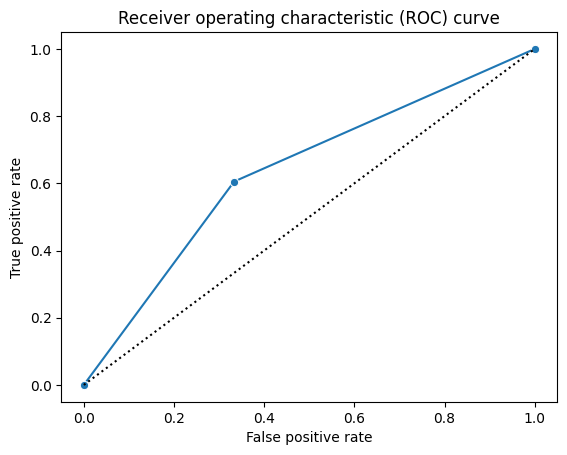

In [53]:
fig = plt.figure()
ax = fig.add_subplot(111)

sns.lineplot(x=fpr, y=tpr, marker = 'o')

plt.title("Receiver operating characteristic (ROC) curve")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.plot([0, 1], [0, 1], color='black', linestyle=':', label="Chance Line")
plt.show()

In [54]:
# AUC for rf_20_model
auc_val = auc(fpr, tpr)
print("AUC of the RF model with", best_ne, "estimators is {:.3f}".format(auc_val))

AUC of the RF model with 50 estimators is 0.636


In [55]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

Accuracy of the RF model with 50 estimators is 0.632


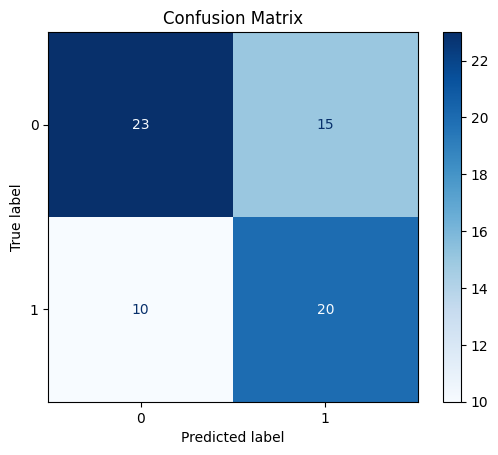

In [56]:
acc_score = accuracy_score(y_test, rf_model_predictions)
print("Accuracy of the RF model with", best_ne, "estimators is {:.3f}".format(acc_score))

cm = confusion_matrix(y_test, rf_model_predictions, labels=[True, False])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

**`ConvNeXT - Getting Embeddings from Test Data`**

In [ ]:
from PIL import Image
from transformers import AutoImageProcessor, ConvNextForImageClassification
import torch

In [ ]:
# load and preprocess data
processor = AutoImageProcessor.from_pretrained("facebook/convnext-tiny-224")

In [ ]:
batch = test.iloc[:50] # test on first 50 images - doesn't work for me if I run all images

In [ ]:
# normalize band between 0 and 1
def normalize_band(band):
    band_min = band.min()
    band_max = band.max()
    return (band - band_min) / (band_max - band_min + 1e-6)

# has to have 3 bands, so reshape band_1 and band_2, average band_1 and band_2 for band_3
def scale_test_imgs(row):
    band_1 = np.array(row.band_1).reshape(75, 75)
    band_2 = np.array(row.band_2).reshape(75, 75)
    band_3 = (band_1 + band_2) / 2

    # normalize bands to [0,1]
    band_1 = normalize_band(band_1)
    band_2 = normalize_band(band_2)
    band_3 = normalize_band(band_3)

    # stack
    img = np.stack([band_1, band_2, band_3], axis=-1)  # shape: (75,75,3)
    return (img * 255).astype(np.uint8)

In [ ]:
# convert to PIL
test_images_pil = [Image.fromarray(scale_test_imgs(row)) for _, row in batch.iterrows()]
processor = AutoImageProcessor.from_pretrained("facebook/convnext-base-224")

# feed images to HuggingFace processor
inputs = processor(images=test_images_pil, return_tensors="pt")

In [ ]:
# load ConvNeXT model
model = ConvNextForImageClassification.from_pretrained(
    "facebook/convnext-base-224",
    num_labels=2, # for binary classification
    ignore_mismatched_sizes=True
)
model.eval()

# move to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

# will give a warning

In [ ]:
# make predictions and get predicted labels
with torch.no_grad():
    outputs = model(**inputs)
    predicted_labels = outputs.logits.argmax(dim=1).cpu().numpy()  # 0 or 1

In [ ]:
# print predicted labels for the first 50 images
predicted_labels

In [ ]:
# save to pkl file
import pickle

pkl_filename = "ConvNeXT_test_images.pkl"

# save list of images
with open(pkl_filename, "wb") as f:
    pickle.dump(test_images_pil, f)

print(f"Saved {len(test_images_pil)} images to {pkl_filename}")